In [1]:
import math
import torch
import gpytorch
import cf_units
import datetime
import zarr
import dask

import dask.array as dsa
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt

torch.set_default_tensor_type('torch.DoubleTensor')

In [2]:
sea_level_picontrol = xr.open_zarr('/scratch/aeb783/data/project/sea_level_picontrol.zarr')

sea_level = sea_level_picontrol["sea_level"]

southern_tip = sea_level_picontrol[dict(time=2000)].sel(xt_ocean=slice(10,30), yt_ocean=slice(-40,-35))


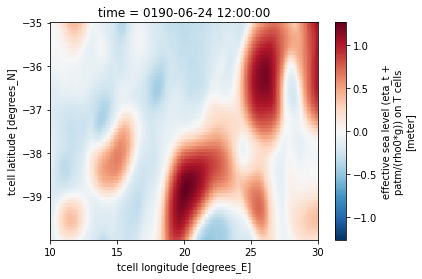

In [3]:
southern_tip['sea_level'].plot()

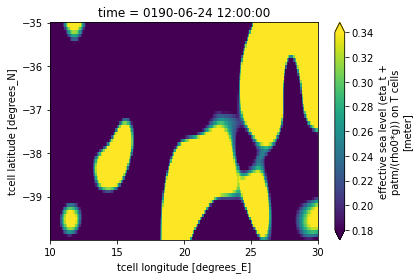

In [4]:
# Plot sea level of selected area
southern_tip['sea_level'].plot(vmin = 0.18, vmax = 0.34)

Text(0.5, 1.0, 'Extrapolation Sea Level')

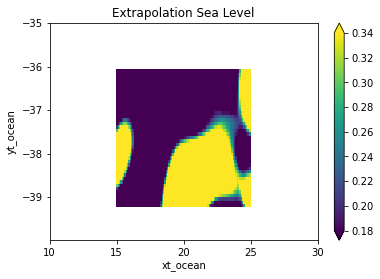

In [28]:
#Select chunk and remove from training data

sea_df = southern_tip['sea_level'].to_pandas()


train_chunk = sea_df[sea_df.isin(sea_df.iloc[10:50,50:150])]

test_chunk = sea_df[sea_df.isin(train_chunk)]



#Plot Training
xr.DataArray(train_chunk1).plot(vmin = 0.18, vmax = 0.34)
plt.title("Extrapolation Sea Level")


Text(0.5, 1.0, 'test Sea Level')

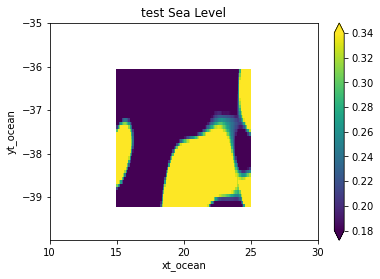

In [29]:
xr.DataArray(test_chunk).plot(vmin = 0.18, vmax = 0.34)
plt.title("test Sea Level")

In [30]:
# Formats sea level data to be compatible with tensor
def format_sea_level(data):
    formatted = []
    for i in range(len(data)):
        formatted.append(data[i])
    
    return torch.FloatTensor((np.array(formatted)).astype(float)).squeeze()


# Convert training and full data to stack format
# & Fill NaN's with blank values
training = train_chunk.stack().reset_index()
print(len(training))
testing = test_chunk.stack().reset_index()
print(len(testing))

# Set training and testing y's
train_y = format_sea_level(np.array(training[0]))
print(len(train_y))
test_y = format_sea_level(np.array(testing[0]))
print(len(test_y))

4000
4000
4000
4000


In [31]:
# Set training and testing x's
train_x = torch.tensor(np.vstack((training['yt_ocean'], training['xt_ocean'])).T).squeeze()
print(len(train_x))

test_x = torch.tensor(np.vstack((testing['yt_ocean'], testing['xt_ocean'])).T).squeeze()
print(len(test_x))


4000
4000


In [32]:
#For plotting purposes only
plot_training = train_chunk.fillna(-1).stack().reset_index()
print(len(plot_training))

plot_test = test_chunk.stack().reset_index()
print(len(plot_test))

plot_training_y = format_sea_level(np.array(plot_training[0]))
print(len(plot_training_y))

plot_test_y = format_sea_level(np.array(plot_test[0]))
print(len(plot_test_y))


plot_training_x = torch.tensor(np.vstack((plot_training['yt_ocean'], plot_training['xt_ocean'])).T).squeeze()
print(len(plot_training_x))


plot_test_x = torch.tensor(np.vstack((testing['yt_ocean'], testing['xt_ocean'])).T).squeeze()
print(len(plot_test_x))

12600
4000
12600
4000
12600
4000


(40, 100)
torch.Size([4000])


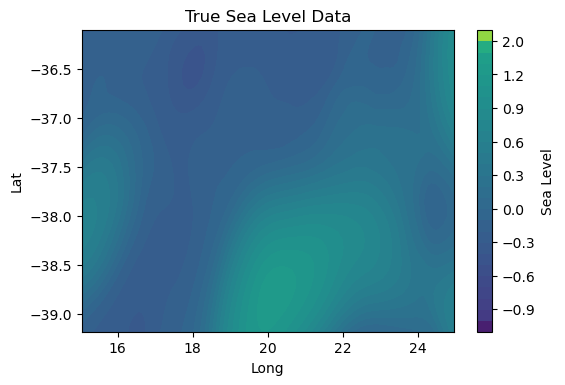

In [34]:
# Plot True Data
test_X_1, test_X_2 = np.meshgrid(test_x[:,1].unique(),test_x[:,0].unique())
print(test_X_1.shape)

print(test_y.shape)

levels = [-2,-1 , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1  ,0, 0.1, 0.2 , 0.3, 0.4 , 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,1.1,1.2,1.3,1.4,2,4]

plt.figure(dpi=100)
plt.contourf(test_X_1, test_X_2,
             test_y.reshape(test_X_1.shape), levels)
plt.title("True Sea Level Data")
plt.xlabel("Long")
plt.ylabel("Lat")
cbar = plt.colorbar()
cbar.ax.set_ylabel('Sea Level')
plt.show()

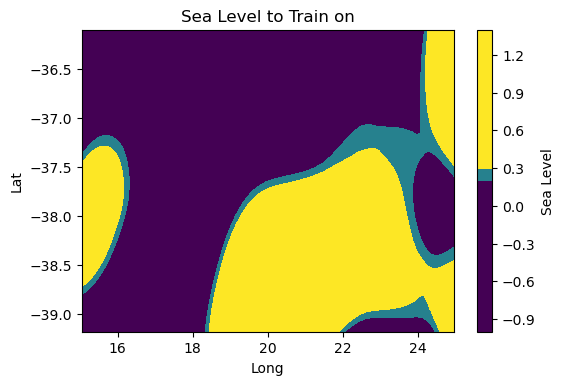

In [38]:
# Plot Extrapolation Chunk
plotting_X_1, plotting_X_2 = np.meshgrid(plot_test_x[:,1].unique(),plot_test_x[:,0].unique())

levels = [-1 , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1  ,0, 0.1, 0.2 , 0.3, 0.4 , 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,1.1,1.2,1.3,1.4]


plt.figure(dpi=100)
plt.contourf(plotting_X_1, plotting_X_2,
             plot_test_y.reshape(plotting_X_2.shape), levels, vmin=0.18, vmax=0.34)
plt.title("Sea Level to Train on")
plt.xlabel("Long")
plt.ylabel("Lat")
cbar = plt.colorbar()
cbar.ax.set_ylabel('Sea Level')
plt.show()

In [39]:
# Calculate mean std of x and y variables
ytrain_mean = train_y.mean()
ytrain_std = train_y.std()

ytest_mean = test_y.mean()
ytest_std = test_y.std()

# Normalize training data
train_y = ((train_y - train_y.mean()) / train_y.std())

# Normalize testing data
test_y = (test_y - test_y.mean()) / test_y.std()

In [40]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        x_mean = self.mean_module(x)
        x_covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(x_mean, x_covar)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)


hypers = {
    'covar_module.base_kernel.lengthscale': torch.tensor(1.7),
}

model.initialize(**hypers)

print(
    model.covar_module.base_kernel.lengthscale.item(),
)


1.6999999999999997


In [41]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
        
    loss.backward()
#     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#         i + 1, training_iter, loss.item(),
#         model.covar_module.base_kernel.lengthscale.item(),
#         model.likelihood.noise.item()
#     ))
    optimizer.step()


In [42]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

n=4000
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    train_pred = model(train_x).mean.detach()

pred_labels = observed_pred.mean.view(n)

# Calc abosolute error
delta_y = torch.abs(pred_labels - test_y).detach().numpy()

/ext3/miniconda3/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


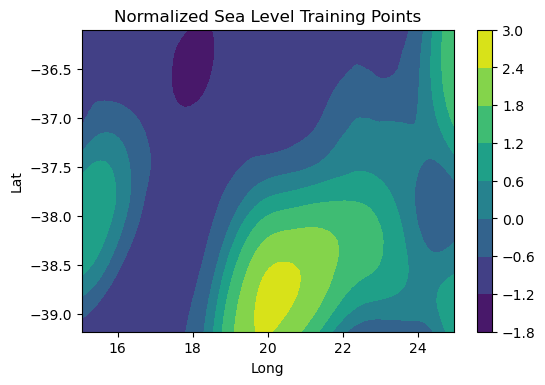

In [43]:
# Plot Sea Level Normalized Training Data
train_X_1, train_X_2 = np.meshgrid(train_x[:,1].unique(),train_x[:,0].unique())

plt.figure(dpi=100)
plt.contourf(train_X_1, train_X_2,
             train_y.reshape(train_X_2.shape))
plt.title("Normalized Sea Level Training Points")
plt.xlabel("Long")
plt.ylabel("Lat")
plt.colorbar()
plt.show()

In [44]:
# Unnormalize Data
train_y = (train_y * ytrain_std) + ytrain_mean
test_y = (test_y * ytest_std) + ytest_mean
train_pred = (train_pred * ytrain_std) + ytrain_mean
pred_labels = (pred_labels * ytrain_std) + ytrain_mean

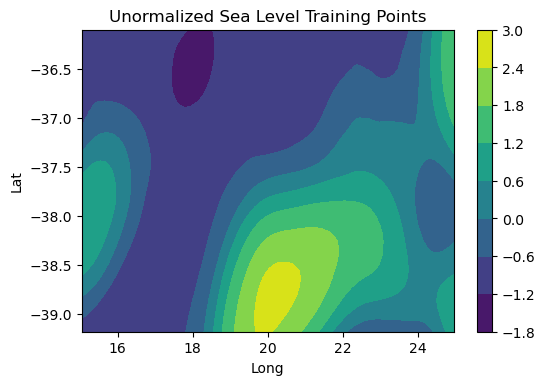

In [45]:
# Plot Sea Level Training Data
train_X_1, train_X_2 = np.meshgrid(train_x[:,1].unique(),train_x[:,0].unique())

plt.figure(dpi=100)
plt.contourf(train_X_1, train_X_2,
             train_y.reshape(train_X_2.shape))
plt.title("Unormalized Sea Level Training Points")
plt.xlabel("Long")
plt.ylabel("Lat")
plt.colorbar()
plt.show()

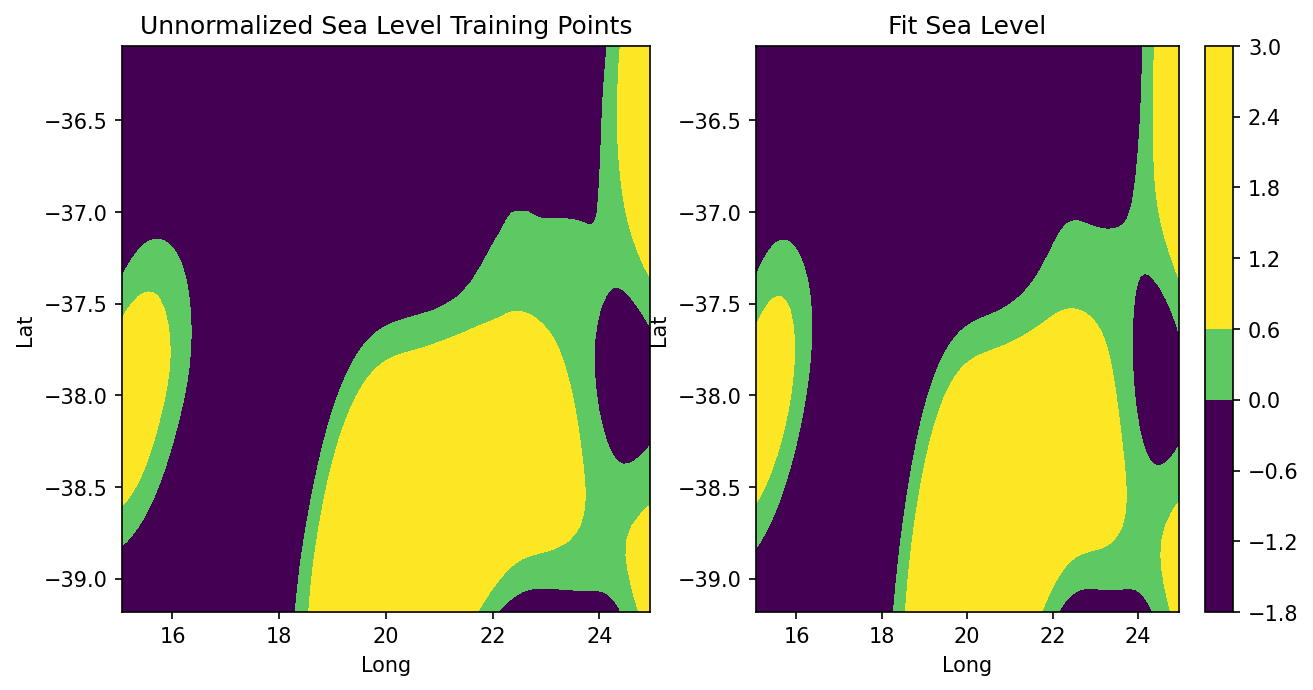

In [46]:
# Plot Training Data and Model Fit
train_X_1, train_X_2 = np.meshgrid(train_x[:,1].unique(),train_x[:,0].unique())
fig, ax = plt.subplots(1, 2, dpi=150, figsize=(10, 5))

ax[0].contourf(train_X_1, train_X_2,
             train_y.reshape(train_X_2.shape), vmin=0.18, vmax=0.34)
ax[0].set_title("Unnormalized Sea Level Training Points")
ax[0].set_xlabel("Long")
ax[0].set_ylabel("Lat")

contour_ = ax[1].contourf(train_X_1, train_X_2,
             train_pred.reshape(train_X_2.shape), vmin=0.18, vmax=0.34)
ax[1].set_title("Fit Sea Level")
ax[1].set_xlabel("Long")
ax[1].set_ylabel("Lat")
fig.colorbar(contour_)
plt.show()

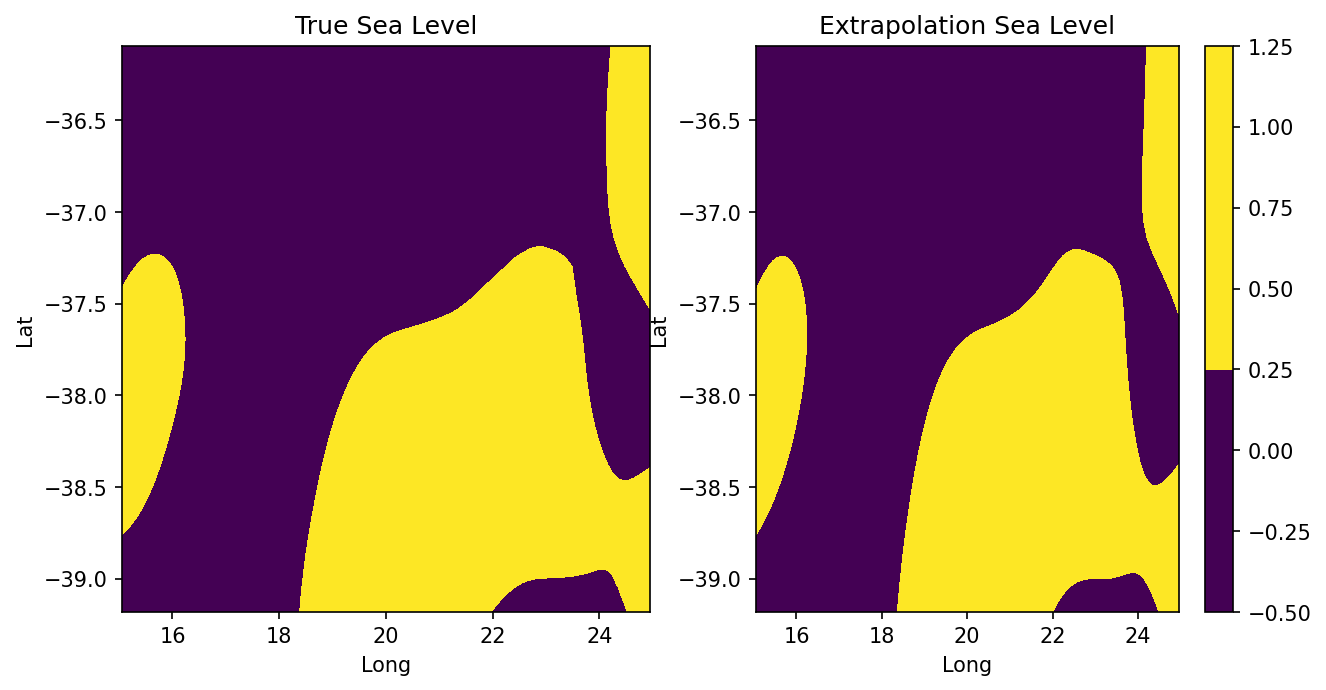

In [20]:
# Plot True Sea Level Data and GP Prediction
test_X_1, test_X_2 = np.meshgrid(test_x[:,1].unique(),test_x[:,0].unique())

fig, ax = plt.subplots(1, 2, dpi=150, figsize=(10, 5))

ax[0].contourf(test_X_1, test_X_2,
             test_y.reshape(test_X_2.shape),vmin=0.18, vmax=0.34) 
ax[0].set_title("True Sea Level")
ax[0].set_xlabel("Long")
ax[0].set_ylabel("Lat")

contour_ = ax[1].contourf(test_X_1, test_X_2,
             pred_labels.detach().reshape(test_X_2.shape),vmin=0.18, vmax=0.34)
ax[1].set_title("Extrapolation Sea Level")
ax[1].set_xlabel("Long")
ax[1].set_ylabel("Lat")
fig.colorbar(contour_)
plt.show()

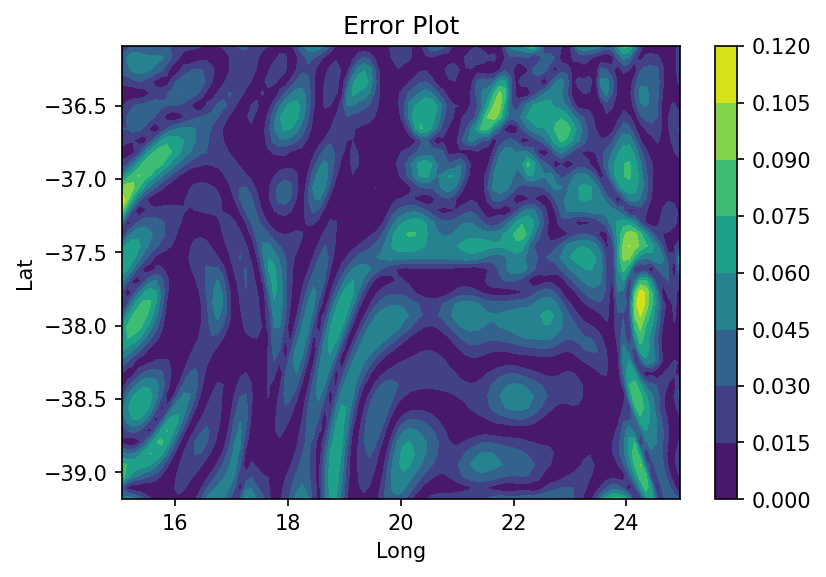

In [21]:
train_X_1, train_X_2 = np.meshgrid(test_x[:,1].unique(),test_x[:,0].unique())

plt.figure(dpi=150)
plt.contourf(train_X_1, train_X_2,
             delta_y.reshape(train_X_2.shape))
plt.title("Error Plot")
plt.xlabel("Long")
plt.ylabel("Lat")
plt.colorbar()
plt.show()